# Training NEOCR dataset using detectron2

## Install detectron2
Please refer this [Github](https://github.com/kanix29/conda_environment)

# Run a pre-trained detectron2 model on Local(Mac)
We first download an image from the COCO dataset:

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import torch, torchvision

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
# define function of display_image for notebook
import matplotlib.pyplot as plt

def display_image(cv2_img):
    plt.figure(figsize=(15,8))
    plt.imshow(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

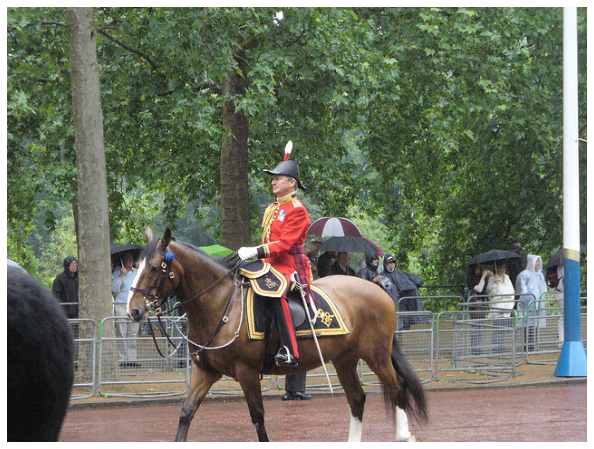

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O sample.jpg
im = cv2.imread("./sample.jpg")

display_image(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.\
**If you run on CPU, change `cfg.MODEL.DEVICE`.**

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Use CPU on Local 
cfg.MODEL.DEVICE = 'cpu'

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/Users/kanie/opt/anaconda3/envs/detectron2/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24])
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4209],
        [ 49.3953, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3803],
        [335.2410, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]]))


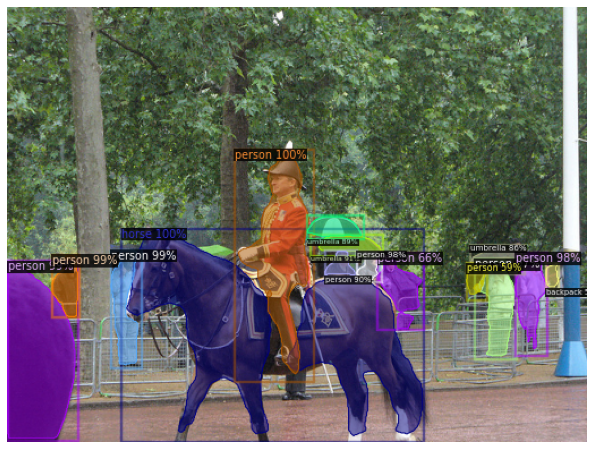

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display_image(out.get_image()[:, :, ::-1])

# Prepare the dataset

Register the NEOCR dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).\
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format.\
See the tutorial for more details.\
This funtion is to use NEOCR dataset(annotated by LabelMe), and you can refer to this function in `utils.py`.

In [3]:
import numpy as np
import glob
import xmltodict
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

from detectron2.structures import BoxMode

def get_neocr_dicts(img_dir, xml_dir):
    xml_files = glob.glob(f'{xml_dir}/*.xml')
    xml_files.sort()

    dataset_dicts = []
    for idx, xml_file in enumerate(tqdm_notebook(xml_files)):
        # Load XML format to Dict
        doc = xmltodict.parse(open(xml_file).read())
        
        filename = os.path.join(img_dir, doc['annotation']['filename'])
        height, width = cv2.imread(filename).shape[:2]
        #record["height"] != doc['annotation']['properties']['height']
        #record["width"] != doc['annotation']['properties']['width']

        record = {}
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # for single object
        if not type(doc['annotation']['object']) == list:
            doc['annotation']['object'] = [doc['annotation']['object']]

        objs = []
        # Explore every object
        for ann_object in doc['annotation']['object']:

            # Get bbox of this object
            rectangle = []
            for pts in ann_object['polygon']['pt']:
                x, y = float(pts['x']), float(pts['y'])
                coordinate = [x, y]
                rectangle.append(coordinate)
            rectangle = np.array(rectangle)

            x_min, y_min = np.min(rectangle, axis=0)
            x_max, y_max = np.max(rectangle, axis=0)

            obj = {
                    "bbox": [x_min, y_min, x_max, y_max],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": 0,
                    # Specify coordinates so that it goes around the boundary.
                    "segmentation": [[x_min, y_min, x_min, y_max, x_max, y_max, x_max, y_min]],
                }

            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [4]:
for d in ["train", "val"]:
    DatasetCatalog.register("neocr_" + d, lambda d=d: get_neocr_dicts("images/" + d, "annotations/" + d))
    MetadataCatalog.get("neocr_" + d).set(thing_classes=["text"])
neocr_metadata = MetadataCatalog.get("neocr_train")

In [5]:
dataset_dicts = get_neocr_dicts("images/train", "annotations/train")

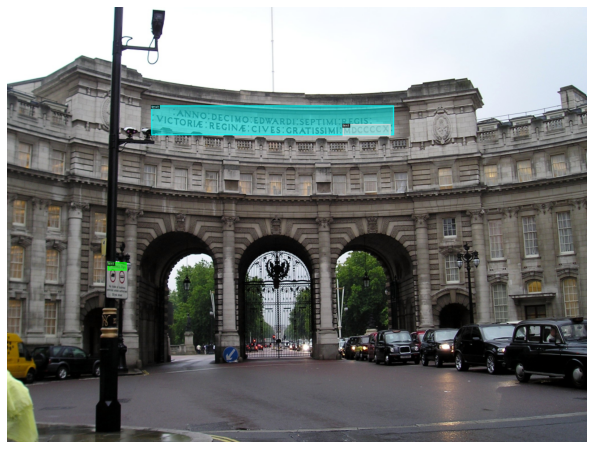

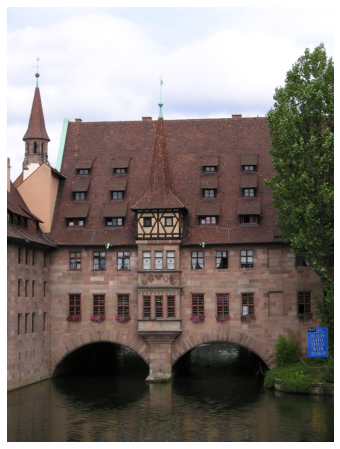

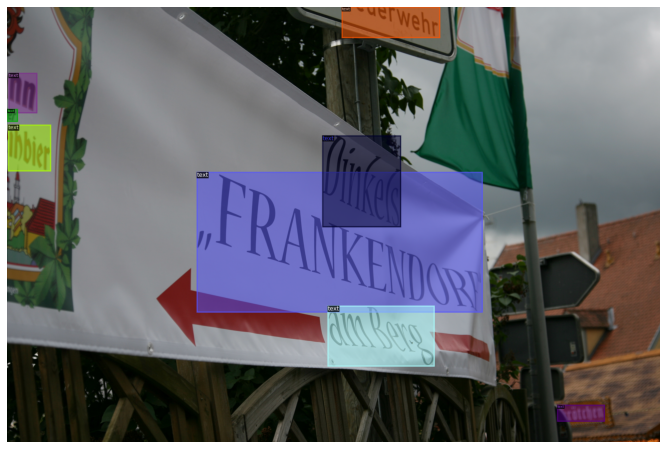

In [10]:
random.seed(50)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=neocr_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    display_image(out.get_image()[:, :, ::-1])

# Training on Google Colab

Now, let's fine-tune a COCO-pretrained R50-FPN R-CNN model on the NEOCR dataset.\
You can use GPU on Google Colab, so you copy the following and execute on Google Colab.

### Usage of Detectron2
* [model_zoo package](https://detectron2.readthedocs.io/modules/model_zoo.html)
* [contents of config](https://github.com/facebookresearch/detectron2/tree/master/configs)


```python
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# All you have to do is detect the bbox.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # detect bbox
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # detect segmentation
cfg.DATASETS.TRAIN = ("neocr_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo / detect box
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # detect segmentation
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
```

## Inference by using the trained model
Now, download train model and let's run inference with the trained model.\
First, let's create a predictor using the model we just trained:

In [6]:
MODEL_PATH = "model/neocr_model_final_v2.pth"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("neocr_train",)
cfg.DATASETS.TEST = ()#("neocr_val",)
cfg.DATALOADER.NUM_WORKERS = 2 # default 4
cfg.SOLVER.IMS_PER_BATCH = 2 # default 16
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR / default 0.001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

cfg.MODEL.DEVICE = 'cpu' # Use CPU on Mac
cfg.MODEL.WEIGHTS = MODEL_PATH # define trained model path 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold

predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [7]:
dataset_dicts = get_neocr_dicts("images/val", "annotations/val")

/Users/kanie/opt/anaconda3/envs/detectron2/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


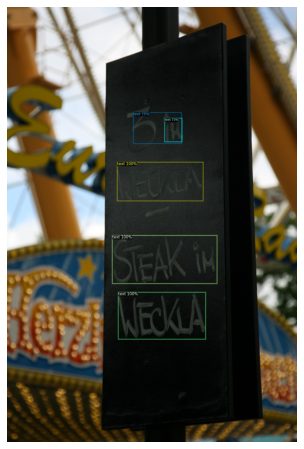

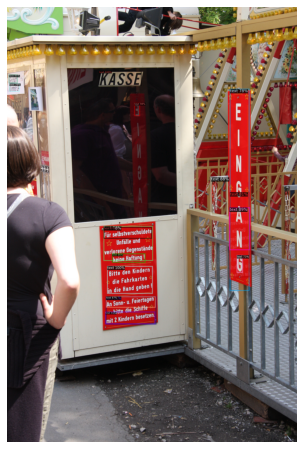

In [8]:
random.seed(10)
for d in random.sample(dataset_dicts, 2):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    display_image(out.get_image()[:, :, ::-1])

# Evaluate trained model
We can also evaluate its performance using AP metric implemented in COCO API.\
It takes ~6 minutes on GPU.\
This gives an AP of ~0. Bad???

In [9]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[08/30 22:20:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res


[08/30 22:21:23 d2.data.build]: Removed 0 images with no usable annotations. 619 images left.
[08/30 22:21:23 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    text    | 5003         |
|            |              |
[08/30 22:21:23 d2.data.common]: Serializing 619 elements to byte tensors and concatenating them all ...
[08/30 22:21:23 d2.data.common]: Serialized dataset takes 0.77 MiB
[08/30 22:21:23 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/30 22:21:23 d2.data.build]: Using training sampler TrainingSampler


In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer

evaluator = COCOEvaluator("neocr_val", cfg, False, output_dir="./output_evaluation/")
val_loader = build_detection_test_loader(cfg, "neocr_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[08/30 22:21:28 d2.evaluation.coco_evaluation]: 'neocr_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [08/30 22:21:28 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output_prediction/neocr_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.



[08/30 22:21:35 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    text    | 235          |
|            |              |
[08/30 22:21:35 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[08/30 22:21:35 d2.data.common]: Serialized dataset takes 0.04 MiB
[08/30 22:21:35 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/30 22:21:35 d2.evaluation.evaluator]: Start inference on 40 images
[08/30 22:21:44 d2.evaluation.evaluator]: Inference done 1/40. 8.8782 s / img. ETA=0:06:24
[08/30 22:21:53 d2.evaluation.evaluator]: Inference done 2/40. 8.5140 s / img. ETA=0:05:42
[08/30 22:22:02 d2.evaluation.evaluator]: Inference done 3/40. 8.7251 s / img. ETA=0:05:35
[08/30 22:22:11 d2.evaluation.evaluator]: Inference done 4/40. 8.7895 s / img. ETA=0:05:25
[08/30 22:22:21 d2.evaluation